# Illustration of Q Learning on the Mountain Car Example

# 1. Some intialization

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from termcolor import colored

env = gym.make('MountainCar-v0')

no_states = env.observation_space
no_actions = env.action_space.n

print("No of state = ", no_states)
print("No of actions =", no_actions)


No of state =  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
No of actions = 3


## Check the environment space

In [2]:
print(env.observation_space.low)
print(env.observation_space.high)

[-1.2  -0.07]
[0.6  0.07]


In [3]:
# Determine size of discretized state space
no_states = (env.observation_space.high - env.observation_space.low)*\
                np.array([10, 100])
no_states = np.round(no_states, 0).astype(int) + 1

print('Number of State= ', no_states )

Number of State=  [19 15]


In [4]:
# Initialize Q table

# The main reason  to populate q table in uniform distribution is that the space X range = [-1.2 -> 0.6 ] and Y= [- 0.07 -> 0.07]. So the distrbution considerd from -1 till +1.  
q_table = np.random.uniform(low = -1, high = 1, 
                        size = (no_states[0], no_states[1], 
                                env.action_space.n))

print('Q table size ', q_table[1] ) 

Q table size  [[ 0.5854188   0.75651103  0.83823173]
 [-0.06465587 -0.39476005 -0.29005838]
 [-0.18210638  0.10935855  0.97240289]
 [ 0.84945462 -0.50989944 -0.43544032]
 [ 0.05052129 -0.91878271  0.30412667]
 [ 0.98720674  0.29022082 -0.9577689 ]
 [-0.66699622  0.04086651 -0.45793305]
 [ 0.82615663  0.96794834 -0.10715541]
 [ 0.71520321 -0.90793191 -0.53629832]
 [ 0.95192489 -0.01836142  0.46225998]
 [-0.94468246 -0.54728785 -0.6060093 ]
 [ 0.25905869 -0.60451029 -0.3586628 ]
 [-0.32803882 -0.57920511 -0.44509804]
 [-0.37005464  0.97453804  0.99868223]
 [ 0.30882949 -0.38813463 -0.059297  ]]


report: The car only has 3 possible actions at every state, it can either accelerate forwards, accelerate backwards, or do nothing. Every time the agent takes an action, the environment (the game) will return a new state (a position and velocity). Hence thre is 3 dimension for 15 column in above print. 

In [5]:
v = np.zeros(no_states)
# v

In [15]:

alpha = 0.6
gamma = 0.99
episodes = 50000
eps_steps = episodes * 2//3
max_eps = 0.9
min_eps = 0.01
eps_a = (max_eps - min_eps)/ eps_steps  # gradient for linear eps-greedy

# 2. Function to implement episilon greedy action selection

In [7]:

def eps_greedy(current_state,step_no,trainingOn):
   
    eps = max(min_eps,  max_eps -  eps_a*step_no)

    if np.random.uniform() < eps and trainingOn:
        action = np.random.randint(0, no_actions)
    else:
        action = np.argmax(q_table[current_state[0],current_state[1]]) 
    return action

# 3. Q Learning algorithm

We carry out a number of episodes, where in each episode we select the next action using epsilon greedy and then repeatedly apply the following update rules:

$Q(s,a) = (1- \alpha)Q(s,a) + \alpha(R(s,a,s') + \gamma V(s'))$ 

$V(s) = \max_{a}{Q(s,a)}$

In [8]:
def update_qtable(state_adj, action, reward,new_state,new_state_adj,done):

    #Allow for terminal states
    if done and new_state[0] >= 0.5:
        q_table[state_adj[0], state_adj[1], action] = reward

    else:
        # delta = alpha *(reward + 
        #                     gamma * np.max(q_table[new_state_adj[0], new_state_adj[1]]) - 
        #                     q_table[state_adj[0], state_adj[1],action])

        # q_table[state_adj[0], state_adj[1],action] += delta
        q_table[state_adj[0],state_adj[1],action] = (1-alpha)*q_table[state_adj[0],state_adj[1],action] + alpha*(reward + gamma*v[new_state_adj[0],new_state_adj[1]])
        
    v[state_adj[0],state_adj[1]] = max(q_table[state_adj[0],state_adj[1]])

    # q_table[state,action] = (1-alpha)*q_table[state,action] + alpha*(reward + gamma*v[new_state])
    
    # v[state] = max(q_table[state])

In [9]:
def q_learning(episodes, trainingOn):
    
    cumulative_reward = 0
    cumulative_steps = 0
    avg_rewards_list = []

    for e in range(1,episodes+1):

        episode_reward = 0
        episode_step_no = 0
        done = False

        # start a new episode
        state = env.reset()

        # Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
        
        while not done:

            # Render environment for last five episodes
            # if e >= (episodes - 20):
            #env.render()

            action = eps_greedy(state_adj,cumulative_steps,trainingOn)
            new_state, reward, done, info = env.step(action)
            
            # Discretize new_state
            new_state_adj = (new_state - env.observation_space.low)*np.array([10, 100])
            new_state_adj = np.round(new_state_adj, 0).astype(int)

            episode_step_no +=1
            cumulative_steps +=1
            episode_reward += reward

            if trainingOn: 
                update_qtable(state_adj, action, reward,new_state,new_state_adj,done)
                
            state_adj = new_state_adj

        print(colored(f'Episode:{e}, Steps = {episode_step_no},   \tReward = {episode_reward}', 'blue'))
        cumulative_reward += episode_reward
        
        avg_rewards_list.append(cumulative_reward/e)

    average_reward = cumulative_reward/episodes 
    print('Average episode reward =',average_reward )

    env.close()
    
    return avg_rewards_list

In [10]:
q_table

array([[[ 3.01724769e-01,  4.15212342e-01, -3.77257869e-01],
        [ 3.24216469e-01, -2.15847654e-01,  5.83707965e-01],
        [-4.97999177e-01, -1.51843024e-01, -7.97977740e-01],
        [-5.90161279e-01,  2.96072001e-01,  9.45479253e-01],
        [-5.21448092e-01, -6.73047562e-01, -2.82617161e-01],
        [-8.35953803e-01,  3.02956352e-01,  8.93921065e-01],
        [ 3.66798902e-01, -1.83790270e-01,  3.55091861e-01],
        [ 1.50502645e-01, -2.33118598e-01,  7.26632293e-01],
        [-7.04008410e-01, -9.06693240e-01,  5.48709076e-02],
        [ 3.32755276e-01, -8.04385052e-01, -7.34446418e-01],
        [-2.51229621e-01,  8.01592009e-01, -4.88931746e-01],
        [-5.19878037e-02,  4.97514302e-01,  6.32536431e-01],
        [-3.05380494e-01, -3.29614198e-02,  9.71838834e-01],
        [-8.87998993e-01, -7.00925111e-01,  8.98024698e-01],
        [-9.95510492e-01, -7.43187357e-01,  9.60464755e-01]],

       [[ 5.85418804e-01,  7.56511031e-01,  8.38231732e-01],
        [-6.46558684e-

# 4. Apply the Q-Learning Algorithm

In [16]:
avg_list = q_learning(episodes, True)

Episode:1, Steps = 200,   	Reward = -200.0
Episode:2, Steps = 200,   	Reward = -200.0
Episode:3, Steps = 200,   	Reward = -200.0
Episode:4, Steps = 200,   	Reward = -200.0
Episode:5, Steps = 200,   	Reward = -200.0
Episode:6, Steps = 200,   	Reward = -200.0
Episode:7, Steps = 200,   	Reward = -200.0
Episode:8, Steps = 200,   	Reward = -200.0
Episode:9, Steps = 200,   	Reward = -200.0
Episode:10, Steps = 200,   	Reward = -200.0
Episode:11, Steps = 200,   	Reward = -200.0
Episode:12, Steps = 200,   	Reward = -200.0
Episode:13, Steps = 200,   	Reward = -200.0
Episode:14, Steps = 200,   	Reward = -200.0
Episode:15, Steps = 200,   	Reward = -200.0
Episode:16, Steps = 200,   	Reward = -200.0
Episode:17, Steps = 200,   	Reward = -200.0
Episode:18, Steps = 200,   	Reward = -200.0
Episode:19, Steps = 200,   	Reward = -200.0
Episode:20, Steps = 200,   	Reward = -200.0
Episode:21, Steps = 200,   	Reward = -200.0
Episode:22, Steps = 200,   	Reward = -200.0
Episode:23, Steps = 200,   	Reward = -200

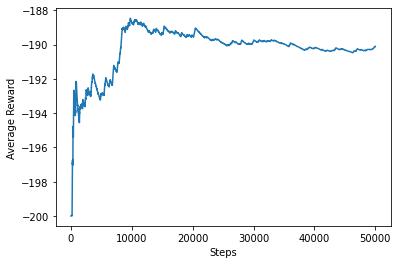

In [17]:
import matplotlib.pyplot as plt

xs = range(1, episodes+1)
plt.plot(xs, avg_list)
plt.xlabel("Steps")
plt.ylabel('Average Reward')
plt.show()

In [18]:
env.reset()
test_episodes = 4000
avg_list2 = q_learning(test_episodes, False)

Episode:1, Steps = 200,   	Reward = -200.0
Episode:2, Steps = 200,   	Reward = -200.0
Episode:3, Steps = 200,   	Reward = -200.0
Episode:4, Steps = 196,   	Reward = -196.0
Episode:5, Steps = 200,   	Reward = -200.0
Episode:6, Steps = 200,   	Reward = -200.0
Episode:7, Steps = 200,   	Reward = -200.0
Episode:8, Steps = 200,   	Reward = -200.0
Episode:9, Steps = 200,   	Reward = -200.0
Episode:10, Steps = 192,   	Reward = -192.0
Episode:11, Steps = 200,   	Reward = -200.0
Episode:12, Steps = 196,   	Reward = -196.0
Episode:13, Steps = 200,   	Reward = -200.0
Episode:14, Steps = 200,   	Reward = -200.0
Episode:15, Steps = 200,   	Reward = -200.0
Episode:16, Steps = 200,   	Reward = -200.0
Episode:17, Steps = 200,   	Reward = -200.0
Episode:18, Steps = 197,   	Reward = -197.0
Episode:19, Steps = 200,   	Reward = -200.0
Episode:20, Steps = 200,   	Reward = -200.0
Episode:21, Steps = 200,   	Reward = -200.0
Episode:22, Steps = 200,   	Reward = -200.0
Episode:23, Steps = 191,   	Reward = -191

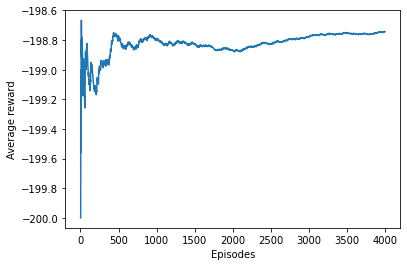

In [19]:
xs2 = range(1, test_episodes+1)
plt.plot(xs2, avg_list2)
plt.xlabel("Episodes")
plt.ylabel("Average reward")
plt.show()